In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal as mvn
import seaborn as sns
import dcor

from jax import grad
import jax.numpy as jnp
import jax.scipy.stats.multivariate_normal as jmvn
from jax.scipy.stats import gaussian_kde as jgaussian_kde

from stein_thinning.thinning import thin, thin_gf, _make_stein_integrand, _make_stein_gf_integrand
from stein_thinning.stein import kmat

from utils.mvn import make_mvn_mixture
from utils.plotting import highlight_points, plot_density

## Generate from a multivariate normal mixture model

For multivariate normal distributions with pdfs
$$f_i(x) = \frac{1}{(2\pi)^{d/2} |\Sigma_i|^{1/2}}\exp\left(-\frac{1}{2}(x - \mu_i)^T \Sigma_i^{-1}(x-\mu_i)\right),$$
where $x \in \mathbb{R}^d$, the mixture pdf with $k$ components is given by
$$f(x) = \sum_{i=1}^k w_i f_i(x),$$
thus the score function is obtained as
$$\nabla \log f(x) = \frac{\sum_{i=1}^k w_i \nabla f_i(x)}{\sum_{i=1}^k w_i f_i(x)} = -\frac{\sum_{i=1}^k w_i f_i(x) \Sigma_i^{-1}(x - \mu_i)}{\sum_{i=1}^k w_i f_i(x)}.$$

Define the functions for the parameters of a multivariate Gaussian mixture:

Choose the parameters of the mixture:

In [2]:
weights = np.array([0.3, 0.7])
means = np.array([
    [-1., -1.],
    [1., 1.],
])
covs = np.array([
    [
        [0.5, 0.25],
        [0.25, 1.],
    ],
    [
        [2.0, -np.sqrt(3.) * 0.8],
        [-np.sqrt(3.) * 0.8, 1.5],
    ]
])

In [3]:
rvs, logpdf, score, logpdf_jax = make_mvn_mixture(weights, means, covs)

Obtain a sample from the mixture:

In [4]:
rng = np.random.default_rng(12345)
sample_size = 1000
sample = rvs(sample_size, random_state=rng)

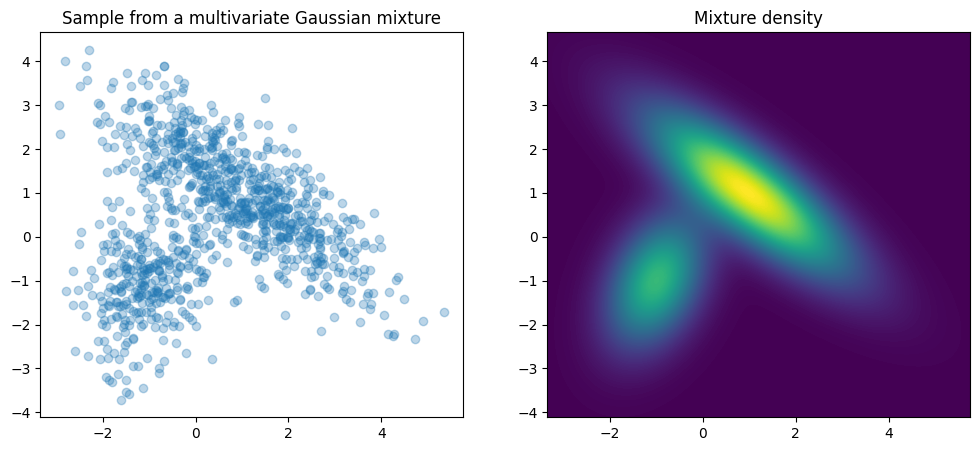

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(sample[:, 0], sample[:, 1], alpha=0.3);
axs[0].set_title('Sample from a multivariate Gaussian mixture');

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

plot_density(lambda x: np.exp(logpdf(x)), axs[1], xlim, ylim, 'Mixture density')

Verify log-pdf against the JAX implementation:

In [6]:
np.testing.assert_array_almost_equal(logpdf(sample), logpdf_jax(sample))

Verify the score function against the JAX implementation:

In [7]:
gradient = score(sample)

In [8]:
score_jax = grad(logpdf_jax)
gradient_jax = jnp.apply_along_axis(score_jax, 1, sample)

In [9]:
np.testing.assert_array_almost_equal(gradient, gradient_jax)

## Thinning

Our aim here is to select a subsample of the posterior sample that best represents the posterior distribution.

In [10]:
thinned_size = 40

### Naive thinning

The easiest way to obtain a subsample from the posterior sample is by retaining each i-th element. In this case, each point is selected independently with the same probability.

In [11]:
idx_naive = np.linspace(0, sample.shape[0] - 1, thinned_size).astype(int)

### Stein thinning

If the gradient of the log-posterior is available, we can use it to perform thinning based on kernel Stein discrepancy:

In [12]:
idx_st = thin(sample, gradient, thinned_size)

### Gradient-free Stein thinning with a simple Gaussian proxy

For gradient-free Stein thinning, we need need the posterior probability for each sample point:

In [13]:
log_p = logpdf(sample)
p = np.exp(log_p)

When the gradient of the log-posterior is not available, we can resort to a gradient-free approximation. This requires us to select a proxy distribution whose gradient is easily computable. The simplest option is to select a multivariate Gaussian with moments matching the sample:

In [14]:
sample_mean = np.mean(sample, axis=0)
sample_cov = np.cov(sample, rowvar=False, ddof=1)

Gradient-free Stein thinning requires us to provide the log-pdf of the proxy distribution and its score function:

In [15]:
log_q = mvn.logpdf(sample, mean=sample_mean, cov=sample_cov)
gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(sample_cov), sample - sample_mean)

We get the indices of the points to select:

In [16]:
idx_gf = thin_gf(sample, log_p, log_q, gradient_q, thinned_size)

### Gradient-free Stein thinning with a KDE proxy

We can obtain a better approximation of the posterior with a KDE of the sample:

In [17]:
kde = jgaussian_kde(sample.T, bw_method='silverman')

We plot the KDE density against the true mixture density:

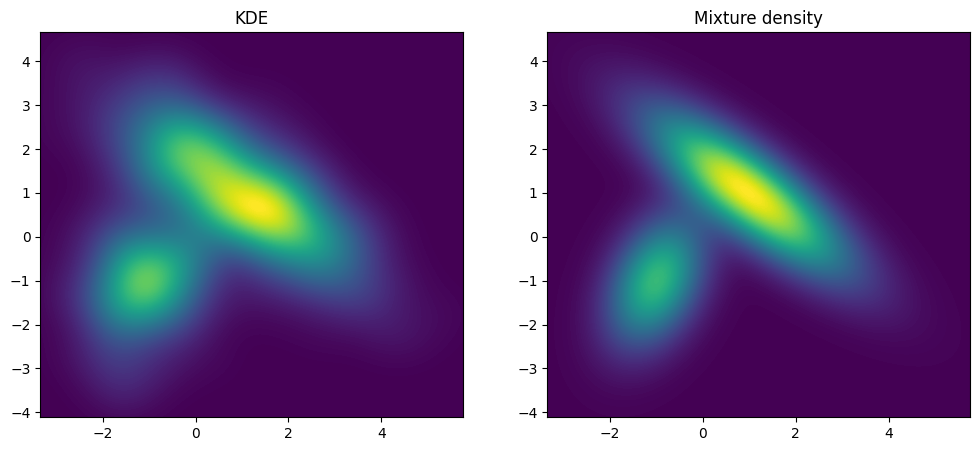

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_density(lambda x: np.exp(kde.logpdf(x.T)), axs[0], xlim, ylim, 'KDE');
plot_density(lambda x: np.exp(logpdf(x)), axs[1], xlim, ylim, 'Mixture density');

For simplicity, we obtain the gradient by numerical differentiation. Since the default choice of kernel for KDE is Gaussian, we could also obtain the gradient explicitly.

In [19]:
def logpdf_and_score(kde, sample):
    log_q = np.array(kde.logpdf(sample.T))
    kde_grad = grad(lambda x: kde.logpdf(x)[0])
    gradient_q = np.array(jnp.apply_along_axis(kde_grad, 1, sample))
    return log_q, gradient_q

In [20]:
log_q_kde, gradient_q_kde = logpdf_and_score(kde, sample)

In [21]:
idx_gf_kde = thin_gf(sample, log_p, log_q_kde, gradient_q_kde, thinned_size)

### Gradient-free Stein thinning with a weighted KDE proxy

A further improvement on the KDE approach is to use the posterior probabilities of the sample points as weights in the KDE approximation:

In [22]:
w = p / np.sum(p)
wkde = jgaussian_kde(sample.T, bw_method='silverman', weights=w)
log_q_wkde, gradient_q_wkde = logpdf_and_score(wkde, sample)

We plot the resulting KDE density against the true mixture density:

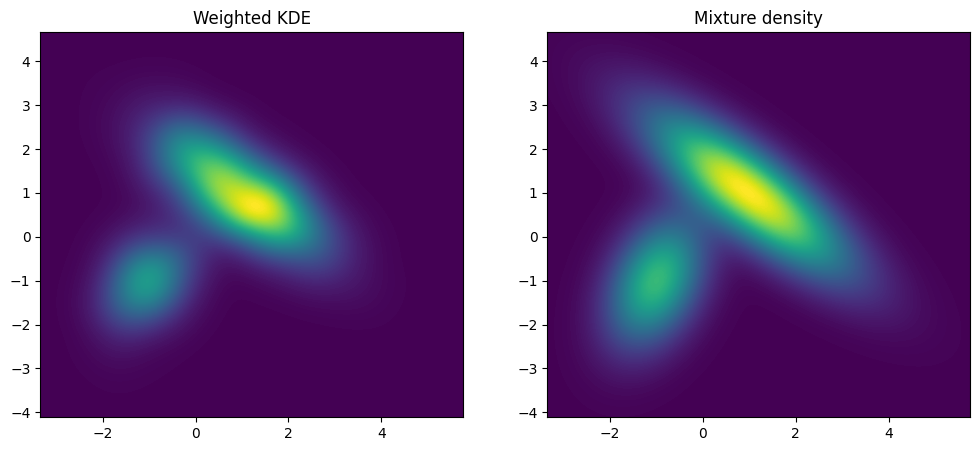

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_density(lambda x: np.exp(wkde.logpdf(x.T)), axs[0], xlim, ylim, 'Weighted KDE');
plot_density(lambda x: np.exp(logpdf(x)), axs[1], xlim, ylim, 'Mixture density');

In [24]:
idx_gf_wkde = thin_gf(sample, log_p, log_q_wkde, gradient_q_wkde, thinned_size)

### Gradient-free Stein thinning with a Laplace approximation

In [25]:
def laplace_approximation(sample):
    res = minimize(lambda x: -logpdf(x), np.mean(sample, axis=0), method='BFGS')
    assert res.success
    return res.x, res.hess_inv

In [26]:
laplace_mean, laplace_cov = laplace_approximation(sample)

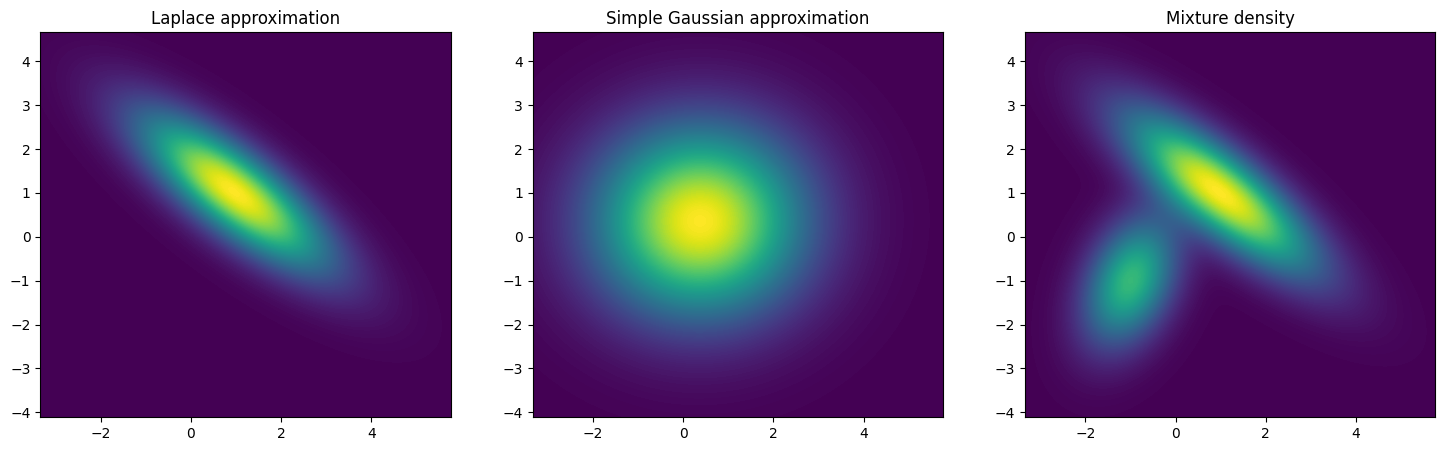

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
plot_density(lambda x: mvn.pdf(x, mean=laplace_mean, cov=laplace_cov), axs[0], xlim, ylim, 'Laplace approximation');
plot_density(lambda x: mvn.pdf(x, mean=sample_mean, cov=sample_cov), axs[1], xlim, ylim, 'Simple Gaussian approximation');
plot_density(lambda x: np.exp(logpdf(x)), axs[2], xlim, ylim, 'Mixture density');

In [28]:
log_q_laplace = mvn.logpdf(sample, mean=laplace_mean, cov=laplace_cov)
gradient_q_laplace = -np.einsum('ij,kj->ki', np.linalg.inv(laplace_cov), sample - laplace_mean)

In [29]:
idx_gf_laplace = thin_gf(sample, log_p, log_q_laplace, gradient_q_laplace, thinned_size)

### Comparison

In [30]:
entries = [
    (idx_naive, 'Naive thinning'),
    (idx_st, 'Stein thinning'),
    (idx_gf, 'Gradient-free Stein thinning: Gaussian proxy'),
    (idx_gf_kde, 'Gradient-free Stein thinning: KDE proxy'),
    (idx_gf_wkde, 'Gradient-free Stein thinning: weighted KDE proxy'),
    (idx_gf_laplace, 'Gradient-free Stein thinning: Laplace proxy'),
]

The number of unique point selected:

In [31]:
def create_table(idx_func, entries):
    return pd.Series([idx_func(idx) for idx, _ in entries], index=[title for _, title in entries])

In [32]:
create_table(lambda idx: len(np.unique(idx)), entries)

Naive thinning                                      40
Stein thinning                                      40
Gradient-free Stein thinning: Gaussian proxy        36
Gradient-free Stein thinning: KDE proxy             40
Gradient-free Stein thinning: weighted KDE proxy    14
Gradient-free Stein thinning: Laplace proxy          1
dtype: int64

Plot the selected points:

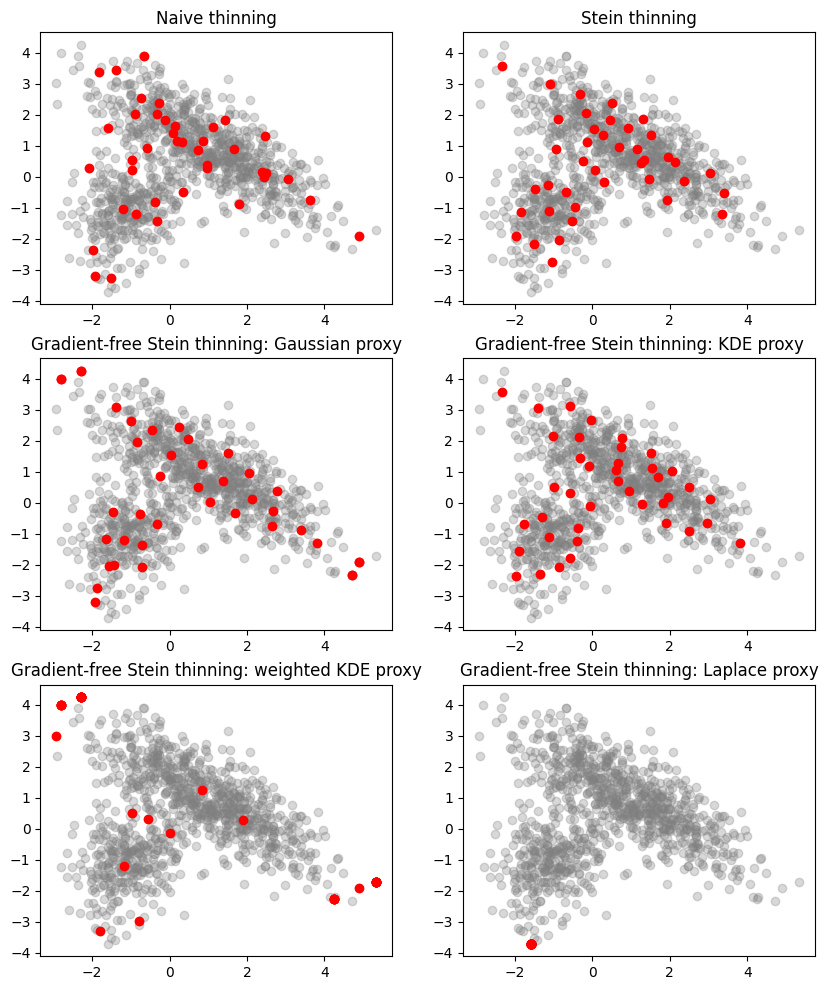

In [33]:
n_cols = 2
n_rows = (len(entries) - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4));
for i, (idx, title) in enumerate(entries):
    ax = axs[i // 2][i % 2]
    highlight_points(sample, idx, ax=ax)
    ax.set_title(title);

#### Energy distance

Compare the energy distance to the full posterior sample:

In [34]:
create_table(lambda idx: np.sqrt(dcor.energy_distance(sample[idx], sample)), entries)

Naive thinning                                      0.200956
Stein thinning                                      0.116144
Gradient-free Stein thinning: Gaussian proxy        0.371942
Gradient-free Stein thinning: KDE proxy             0.095249
Gradient-free Stein thinning: weighted KDE proxy    1.245123
Gradient-free Stein thinning: Laplace proxy         2.616142
dtype: float64

To evaluate how well the thinned sample approximates the true distribution, we draw a new sample from the distribution and calculate the energy distance:

In [35]:
sample2 = rvs(sample_size, random_state=rng)

In [36]:
create_table(lambda idx: np.sqrt(dcor.energy_distance(sample[idx], sample2)), entries)

Naive thinning                                      0.208667
Stein thinning                                      0.104302
Gradient-free Stein thinning: Gaussian proxy        0.410703
Gradient-free Stein thinning: KDE proxy             0.109114
Gradient-free Stein thinning: weighted KDE proxy    1.270934
Gradient-free Stein thinning: Laplace proxy         2.641829
dtype: float64

#### Performance of weighted KDE

We have seen that the performance of the gradient-free algorithm with a weighted KDE is unsatisfactory. The scatter plot of the selected points suggests that the algorithm picks points that have a low probability. We can confirm this by highlighting the points with the lowest probability in the sample:

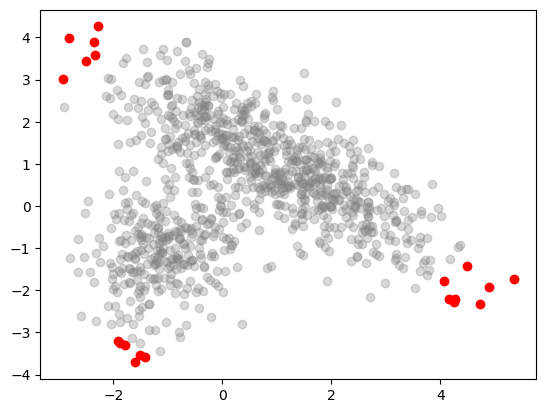

In [37]:
highlight_points(sample, np.argsort(log_q)[:20])

The gradient-free integrand includes the multiplier $q(x)/p(x)$. In the plain KDE, $q(x)$ will be proportional to the density of sample points in te vicinity of $x$. Applying weights has the effect of reducing $q(x)$ further, thus penalising the points in the low-probability area twice.

We can confirm that the values of $\log q(x) - \log p(x)$ are commensurate across the sample for the standard KDE but not for the weighted KDE:

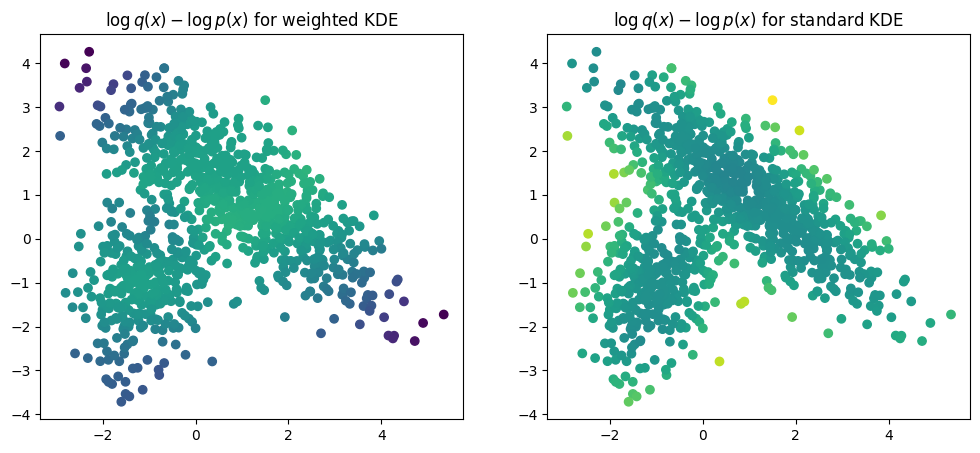

In [38]:
vals = np.concatenate([log_q_wkde - log_p, log_q_kde - log_p])
vmin = np.min(vals)
vmax = np.max(vals)

fig, axs = plt.subplots(1, 2, figsize=(12, 5));

scatter = axs[0].scatter(sample[:, 0], sample[:, 1], c=log_q_wkde - log_p, vmin=vmin, vmax=vmax);
axs[0].set_title('$\\log q(x) - \\log p(x)$ for weighted KDE');

axs[1].scatter(sample[:, 0], sample[:, 1], c=log_q_kde - log_p, vmin=vmin, vmax=vmax);
axs[1].set_title('$\\log q(x) - \\log p(x)$ for standard KDE');

Here we compare the values on the diagonal of the integrand matrix, which the algorithm would use in its first step:

In [39]:
integrand_st = _make_stein_integrand(sample, gradient)
integrand_kde = _make_stein_gf_integrand(sample, log_p, log_q_kde, gradient_q_kde)
integrand_wkde = _make_stein_gf_integrand(sample, log_p, log_q_wkde, gradient_q_wkde)

In [40]:
integrands = [integrand_st, integrand_kde, integrand_wkde]
kmats = [kmat(integrand, sample.shape[0]) for integrand in integrands]

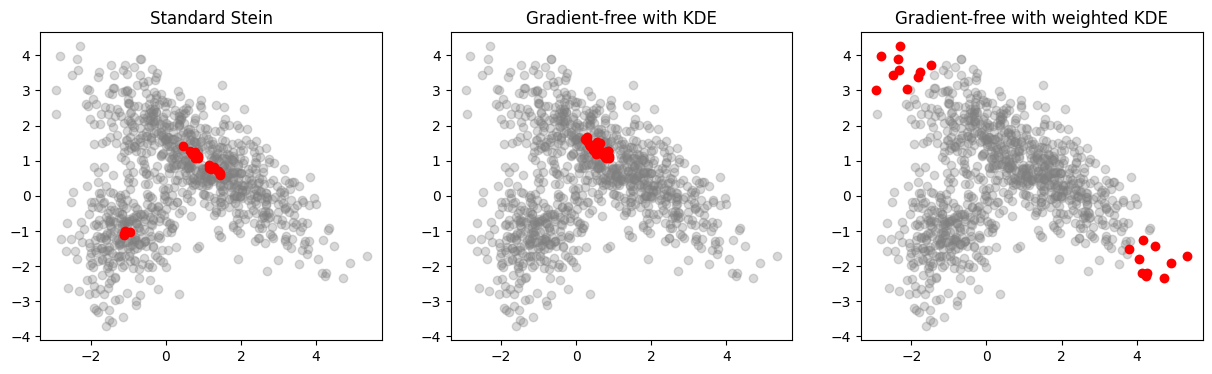

In [41]:
titles = ['Standard Stein', 'Gradient-free with KDE', 'Gradient-free with weighted KDE']
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, km in enumerate(kmats):
    highlight_points(sample, np.argsort(np.abs(np.diag(km)))[:20], ax=axs[i])
    axs[i].set_title(titles[i]);

By contrast, the norm of the gradient is reasonably well approximated by both the KDE and the weighted KDE choices:

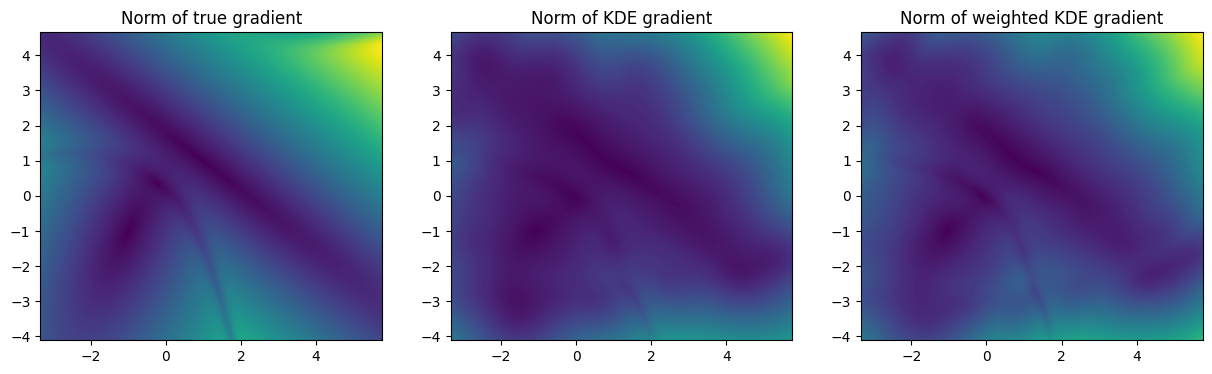

In [42]:
kde_grad = grad(lambda x: kde.logpdf(x)[0])
wkde_grad = grad(lambda x: wkde.logpdf(x)[0])

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_density(lambda x: np.linalg.norm(score(x), axis=1), axs[0], xlim, ylim, 'Norm of true gradient');
plot_density(lambda x: np.linalg.norm(jnp.apply_along_axis(kde_grad, 1, x), axis=1), axs[1], xlim, ylim, 'Norm of KDE gradient');
plot_density(lambda x: np.linalg.norm(jnp.apply_along_axis(wkde_grad, 1, x), axis=1), axs[2], xlim, ylim, 'Norm of weighted KDE gradient');

### Performance of the Laplace approximation

We have seen above that the Laplace approximation fails to produce a good proxy for this sample. Here we confirm that the problem again is that the ratio $q(x) / p(x)$ becomes very small for some points.

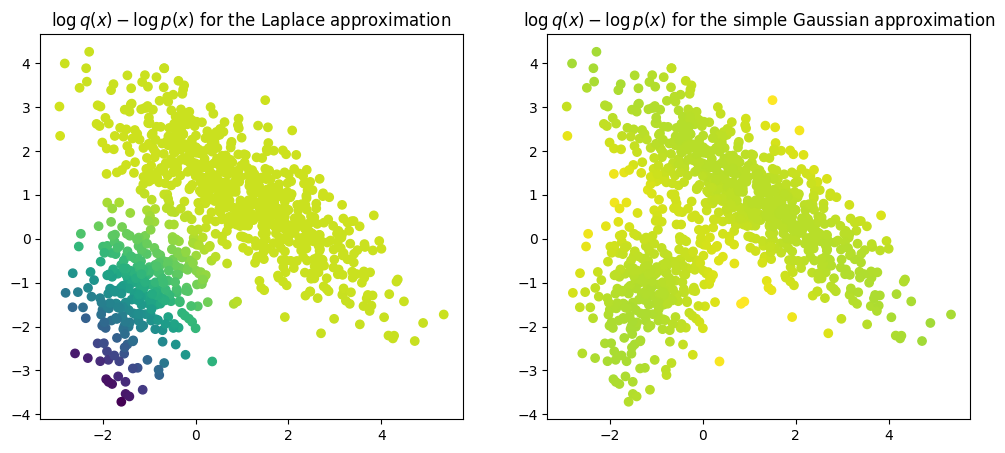

In [43]:
vals = np.concatenate([log_q - log_p, log_q_laplace - log_p])
vmin = np.min(vals)
vmax = np.max(vals)

fig, axs = plt.subplots(1, 2, figsize=(12, 5));

scatter = axs[0].scatter(sample[:, 0], sample[:, 1], c=log_q_laplace - log_p, vmin=vmin, vmax=vmax);
axs[0].set_title('$\\log q(x) - \\log p(x)$ for the Laplace approximation');

axs[1].scatter(sample[:, 0], sample[:, 1], c=log_q - log_p, vmin=vmin, vmax=vmax);
axs[1].set_title('$\\log q(x) - \\log p(x)$ for the simple Gaussian approximation');